In [1]:
# voxel morph imports
import tensorflow as tf
import voxelmorph as vxm
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

import numpy as np
import h5py

import utilitary as util

#plotting
import matplotlib.pyplot as plt
import neurite as ne

In [2]:
hf = h5py.File("epfl3.h5", "r")

In [3]:
nb_entries = len(hf.keys())
list_keys = list(hf.keys())
keys_random = np.random.permutation(list_keys)

x,y,z = hf.get("0")["frame"][0].shape

In [4]:
np.random.seed(336699)

nb_entries = len(hf.keys())
list_keys = list(hf.keys())
keys_random = np.random.permutation(list_keys)

keys_train = keys_random[:int(nb_entries*0.8)]
keys_test  = keys_random[int(nb_entries*0.8):]

In [5]:
# print keys in test with labels mask
mask_tests = []
npz_test_idx = [] # required to pull the correct npz
for j, i in enumerate(keys_test):
    if len(hf.get(i)) > 1:
        mask_tests.append(i)
        npz_test_idx.append(j)
        
# print keys in test with labels mask
mask_trains = []
npz_train_idx = [] # required to pull the correct npz
for j, i in enumerate(keys_train):
    if len(hf.get(i)) > 1:
        mask_trains.append(i)
        npz_train_idx.append(j)

In [38]:
npz_test_idx[:10]

[39, 42, 64, 88, 100, 103, 109, 133, 140, 160]

In [6]:
#load the test set + normalization
slices_test_3d_frame = np.empty((len(mask_tests),112,112,32))
slices_test_3d_mask = np.empty((len(mask_tests),112,112,32))
for i, key in enumerate(mask_tests):
    slices_test_3d_frame[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255
    slices_test_3d_mask[i] = np.array(hf.get(key)["mask"])
    #slices_test_3d_mask[i][np.where(slices_train_3d_mask[i] != 4)] = 0

In [7]:
#load the training set + normalization
slices_train_3d_frame = np.empty((len(mask_trains),112,112,32))
slices_train_3d_mask = np.empty((len(mask_trains),112,112,32))
for i, key in enumerate(mask_trains):
    slices_train_3d_frame[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255
    slices_train_3d_mask[i] = np.array(hf.get(key)["mask"])
    #slices_train_3d_mask[i][np.where(slices_train_3d_mask[i] != 4)] = 0

In [8]:
vol_shape = (112, 112, 32)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

label_vals = np.array([1,2,3,4,5,6,7])

vxm_model = vxm.networks.VxmDenseSemiSupervisedSeg(
                                        inshape=vol_shape,
                                        nb_labels=len(label_vals),
                                        nb_unet_features=nb_features,
                                        int_steps=0);

fixed_vol = np.array(hf.get('1')["frame"][0][:,:,:])/255

lambda_ = 0.05
title = "wght_3d_semisup_" + str(lambda_) + ".keras"
vxm_model.load_weights("wght_3d_semisup_f1_250step_0.05.keras")

Instructions for updating:
Use fn_output_signature instead


In [21]:
### PREDICTION ON UNSEEN DATA

#val -> test npz
vols_names = ['val'+str(i)+'.npz' for i in npz_test_idx]

predict_generator = vxm.generators.semisupervised(
                        vol_names=vols_names,
                        labels=label_vals)

#predict_generator = util.vxm_data_generator(slices_train_3d_frame,
                                         # vol_fixed=fixed_vol,
                                          #batch_size=1)

val_input = [next(predict_generator) for i in range(len(mask_tests))]

# predict the transformation
val_pred = []
for i in range(len(mask_tests)):
    val_pred.append(vxm_model.predict(val_input[i]))
    
#warp_generator = util.vxm_data_generator(slices_train_3d_mask,
                                         # vol_fixed=fixed_vol,
                                          #batch_size=1)

In [15]:
### PREDICTION ON TRAINING DATA

#vol -> training npz
vols_names_tr = ['vol'+str(i)+'.npz' for i in npz_train_idx]

predict_generator = vxm.generators.semisupervised(
                        vol_names=vols_names_tr,
                        labels=label_vals)

#predict_generator = util.vxm_data_generator(slices_train_3d_frame,
                                         # vol_fixed=fixed_vol,
                                          #batch_size=1)

val_input = [next(predict_generator) for i in range(len(mask_trains))]

# predict the transformation
val_pred = []
for i in range(len(mask_trains)):
    val_pred.append(vxm_model.predict(val_input[i]))

# predict the transformation

In [10]:
def dice_coef(pred, true, k = 0):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    # returns values between 0 and 1
    return 1-dice

def avg_dice_score(pred, true):
    dice_score = []
    for i in range(pred.shape[0]):
        dice_score.append(dice_coef(pred[i],true))
    return np.mean(dice_score), np.std(dice_score)

In [11]:
warp_model = vxm.networks.Transform(vol_shape, interp_method='nearest')

In [12]:
fixed_seg = np.array(hf.get('1')["mask"])
#fixed_seg[np.where(fixed_seg != 4)] = 0

In [22]:
#checking that it's the right prediction vector
assert (len(mask_tests) == len(val_pred))

# predict the labels transformation (unseen data)
warped_seg = [warp_model.predict([slices_test_3d_mask[i][np.newaxis,...,np.newaxis], val_pred[i][1]]) for i in range(len(mask_tests))]

mean_dice, std_dice = avg_dice_score(slices_test_3d_mask, fixed_seg)
print("before warping (rough alignment)")
print(mean_dice)
print(std_dice)
warped_seg = np.array(warped_seg)
mean_dice, std_dice = avg_dice_score(warped_seg.squeeze(), fixed_seg)
print("after warping")
print(mean_dice)
print(std_dice)

before warping (rough alignment)
0.3981743449386853
0.13450531697306672
after warping
0.4314307613184301
0.17914031815019205


In [23]:
#checking that it's the right prediction vector
assert (len(mask_trains) == len(val_pred))

# predict the labels transformation (training data)
warped_seg = [warp_model.predict([slices_train_3d_mask[i][np.newaxis,...,np.newaxis], val_pred[i][1]]) for i in range(len(mask_trains))]

mean_dice, std_dice = avg_dice_score(slices_train_3d_mask, fixed_seg)
print("before warping (rough alignment)")
print(mean_dice)
print(std_dice)
warped_seg = np.array(warped_seg)
mean_dice, std_dice = avg_dice_score(warped_seg.squeeze(), fixed_seg)
print("after warping")
print(mean_dice)
print(std_dice)

IndexError: list index out of range

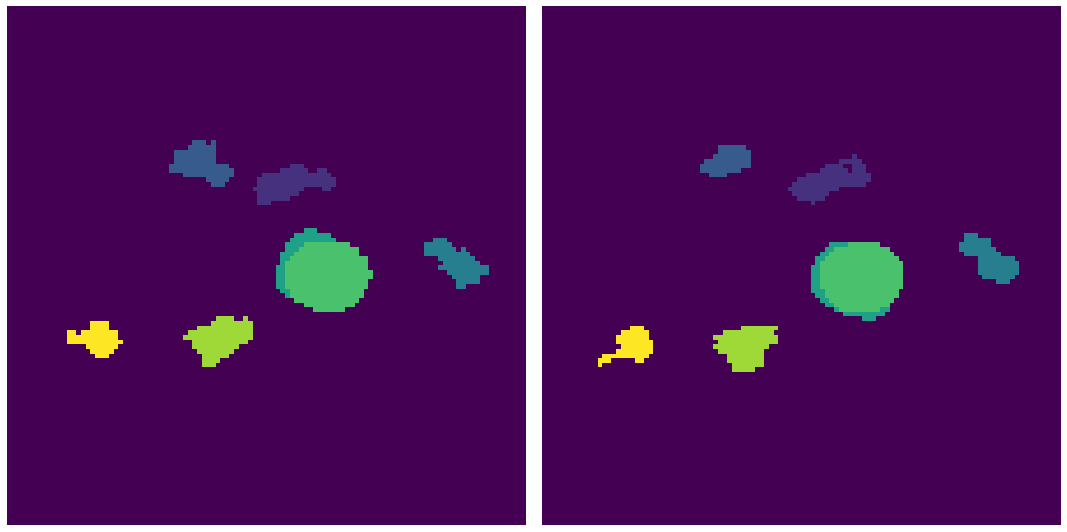

(<Figure size 1080x540 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [21]:
ne.plot.slices([np.max(slices_test_3d_mask[13],axis=2),np.max(fixed_seg, axis=2)])

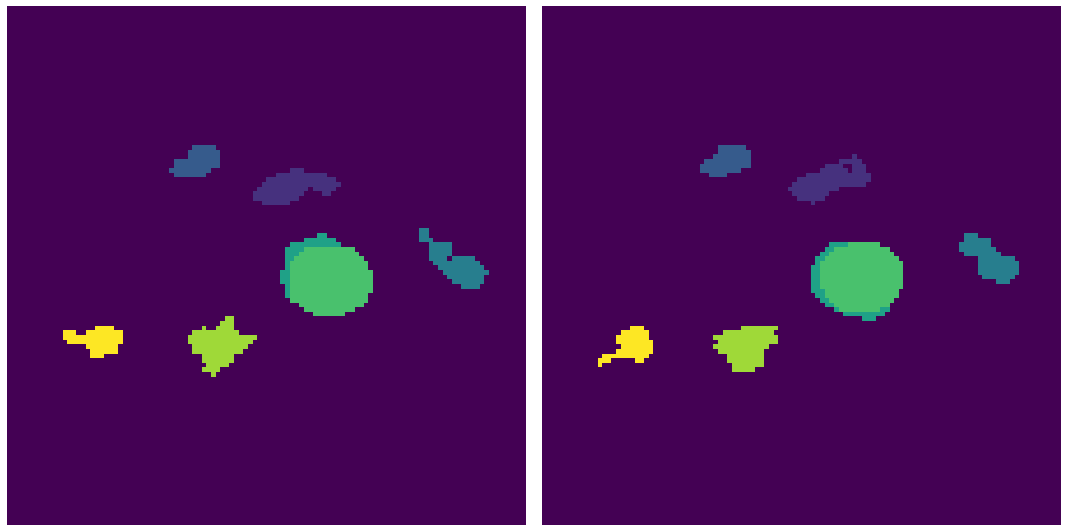

(<Figure size 1080x540 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [34]:
ne.plot.slices([(np.max(slices_train_3d_mask[13]-warped_seg[13].squeeze(),axis=2)), np.max(fixed_seg, axis=2)])

In [25]:
(np.max(slices_train_3d_mask[13],axis=2)-np.max(warped_seg[13].squeeze(),axis=2)).sum()

-74.0

In [26]:
(slices_train_3d_mask[13]-warped_seg[13].squeeze()).sum()

-1315.0

# Semi-supervised (Code pas terminé à partir de là)